In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cond_color
from cond_color import get_colors, plot_start, plot_end

In [2]:
data = np.load(r"psths.npz")

X = data['X']  # N × C × T; N = 182 neurons; T = 130 time-bins; C = 108
# X[i,c,t] is the average firing rate of neuron i in the t-th time bin in condition c (in units of Hz or spikes per second)
mean_c = np.mean(X[:,:,:],dtype=np.float64, axis=1)
mean_c_i = np.mean(mean_c, dtype=np.float64, axis=0)


# NORMALISING
for i in range(182):
    c_t_mat = X[i,:,:]
    c_t_flat = np.ndarray.flatten(c_t_mat)  # make it 1D
    maximum = max(c_t_flat)  # find max value accross time and conditions
    minimum = min(c_t_flat)
    #print(maximum, minimum)
    X[i,:,:] = (X[i,:,:] - minimum)/ (maximum - minimum + 5) # normalising


# MEAN CENTERING
# Calculate the mean across conditions for each neuron and time bin
mean_c = np.mean(X, axis=1, dtype=np.float64)  # Shape (N, T); # taking average across all conditions, c
# Reshape mean for broadcasting
mean_c_expanded = np.expand_dims(mean_c, axis=1)  # Shape (N, 1, T)  # expanded it along the condition axis 
# i.e., you don't need to take the mean again across all neurons, i, but need to find a 2D array of mean values
# Mean-center the data
meancentredX = X - mean_c_expanded

In [3]:
def createVmZ(X, M, N, C, T):
    Xreshaped = np.reshape(X, newshape=(N, C*T))
    print(Xreshaped.shape)

    sample_cov_mat = (1 / (C * T)) * (Xreshaped @ Xreshaped.T)
    print(sample_cov_mat.shape)

    eigvals, eigvects = np.linalg.eigh(sample_cov_mat)  # Use eigh for symmetric matrices
    print(eigvects.shape)

    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]  # sort and reverse list
    eigvals = eigvals[sorted_indices]
    eigvects = eigvects[:, sorted_indices]

    V_m = eigvects[:,:M]  # V_M now has shape (N, M)
    print('Vm', V_m.shape)
    # Projecting the data onto the selected eigenvectors (principal components)
    Z = V_m.T @ Xreshaped  # Shape of Z is (M, C*T)
    print('Z', Z.shape)
    Zreshaped = np.reshape(Z, newshape=(M, C, T))

    return V_m, Zreshaped


In [4]:
# Z MUST BE 3D i.e., HAVE SHAPE LIKE (12, 108, 46)

def createA(Z, M, C, T):
    
    K = int(M*(M-1)*0.5)
    H = np.zeros((K, M, M))

    a = 0 # a = beta index; also the index for row of the KxMxM matrix
    for i in range(M):  # a = row, i = column, j = into the page
        for j in range(i+1, M):  # Upper triangular indices
            H[a,i,j] = 1
            H[a,j,i] = -1
            a += 1

    print(Z.shape)  # (12, 108, 46)

    deltaZ = np.zeros((M, C, T-1))  # One less time bin
    for t in range(T-1):   # Compute time differences
        deltaZ[:,:,t] = Z[:,:,t+1] - Z[:,:,t]
    print(deltaZ.shape)  # (12, 108, 45)
    deltaZ = np.reshape(deltaZ, newshape=(M, C*(T-1)))  # Reshape to (M, T-1)
    print('deltaZ', deltaZ.shape)  # (12, 4860)

    deltaZ_flat = deltaZ.flatten()
    print('deltaZflat', deltaZ_flat.shape)

    print('Z', Z.shape)  # (12, 108, 46)
    #Zreshaped = np.reshape(Z[:,108*45], newshape=(M, 108 * 45)) # Reshape to trials and time steps
    Zsliced = Z[:,:,:(T-1)]
    print("Zsliced", Zsliced.shape)  # (12, 108, 45)

    # Compute W = H * Z
    W = np.tensordot(H, Zsliced, axes=1)
    print("W", W.shape)

    W_flat = W.reshape(K, M * C*(T-1))
    print(W_flat.shape)

    b = W_flat @ deltaZ_flat
    print(b.shape)  # should be a K-dimensional vector
    Q = W_flat @ W_flat.T
    print(Q.shape)  # should be K x K

    beta = np.linalg.solve(Q,b)
    print(beta.shape)

    A = np.tensordot(beta, H, axes=1)

    return A



In [5]:
def createP_FR(A, Z, idx, M):
    eigvals, eigvects = np.linalg.eig(A)
    IMAGeigvals = np.imag(eigvals)
    sorted_indices = np.argsort(IMAGeigvals)[::-1]  # sort and reverse list
    # firsteigval = IMAGeigvals[sorted_indices][idx]
    firsteigvect = eigvects[:, sorted_indices][idx]

    # don't know if I need to normalise each row in the matrix or everything in the matrix...
    realfirsteigvect = np.real(firsteigvect)
    normrealfirsteigvect = realfirsteigvect/(np.linalg.norm(realfirsteigvect))

    imagfirsteigvect = np.imag(firsteigvect)
    normimagfirsteigvect = imagfirsteigvect / (np.linalg.norm(imagfirsteigvect))

    P_FR = np.zeros((2, M))
    print('P_FR', P_FR.shape)
    P_FR[0] = normrealfirsteigvect.T
    P_FR[1] = normimagfirsteigvect.T

    proj = np.tensordot(P_FR, Z, axes=1)
    print('proj', proj.shape)

    return proj, P_FR

In [6]:
M = 12
MovX = meancentredX[:,:,65:111]
print(MovX.shape)
Vm, Z = createVmZ(MovX, M, N=182, C=108, T=46)

(182, 108, 46)
(182, 4968)
(182, 182)
(182, 182)
Vm (182, 12)
Z (12, 4968)


In [7]:
M = 12
C = 108
T = 46
#Zreshaped = np.reshape(Z, newshape=(M, C, T))
A = createA(Z, M = 12, C=108, T = 46)


(12, 108, 46)
(12, 108, 45)
deltaZ (12, 4860)
deltaZflat (58320,)
Z (12, 108, 46)
Zsliced (12, 108, 45)
W (66, 12, 108, 45)
(66, 58320)
(66,)
(66, 66)
(66,)


6)Pre-movement period: Apply the projections obtained for the interval [-150ms, 300ms] to the
interval [-800ms, -150ms], which we will refer to as the pre-movement period. Specifically, combine
the exact same PC-projection matrix VM obtained in exercise 2c with the projection onto the FR
plane found in 5b to obtain the 2 ×N projection matrix PFR VT
M (where T denotes transposition),
which you will use to directly project the N dimensional trajectories during this pre-movement period
(corresponding to an appropriate slice or sub-array of the normalized and mean-centered X obtained
at the end of exercise 2b) onto the FR plane. 


Plot these trajectories superimposed on those plotted in
5c (the movement interval trajectories), but with a different color code: green replaced by cyan and
red by magenta. To this end, use cond color.get colors as in 3 and 5c, but with the optional input
alt colors set to True, and with the xs and ys inputs now giving the coordinates of the final points
of the pre-movement period trajectories. (In order to make this joint plot less busy, feel free to reduce
the alpha value15 of the plotted trajectories during the movement period, which were already plotted
separately in 5c.)


Q: How do these trajectories differ from the ones after movement-related activity has begun?


Q: Assuming the rotational dynamics observed during the period of movement-related activity is indeed
autonomous, how can you interpret the projected trajectories during the preceding (pre-movement)
interval? Think about the epoch in the task: what does the monkey know in this epoch (specifically
after the target onset, but before the go-cue or movement onset)?

In [8]:
idx = 0 # choosing fastest plane of rotation
MovProj, P_FR = createP_FR(A, Z, idx, M)

print(Vm.shape)
print(P_FR.shape)

Pfr_Vm = P_FR @ Vm.T
print('Pfr_Vm', Pfr_Vm.shape)

PreMovX = meancentredX[:,:,:65]  # N dimensional trajectory during pre-movement period
print('PreMovX', PreMovX.shape)

ProjPreMovX = np.tensordot(Pfr_Vm, PreMovX, axes = 1)
print('ProjPreMovX', ProjPreMovX.shape)

P_FR (2, 12)
proj (2, 108, 46)
(182, 12)
(2, 12)
Pfr_Vm (2, 182)
PreMovX (182, 108, 65)
ProjPreMovX (2, 108, 65)


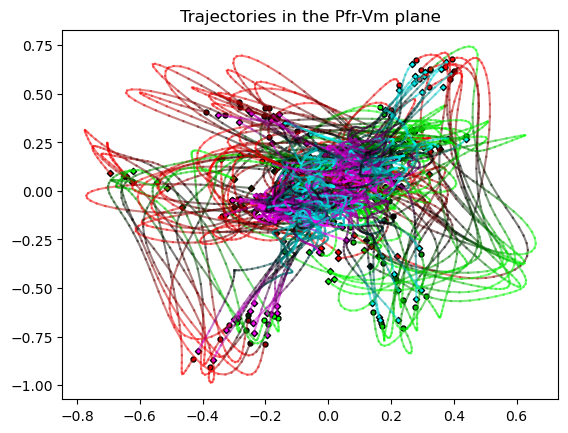

In [11]:
for c in range(C):
     # just randonmly pick the 5th condition - we have assumed that the autonomous dynamics is the same in all conditions 
     # plt.plot(Z_PC1_PC2reshaped[0,c,:], Z_PC1_PC2reshaped[1,c,:])
    xs, ys = MovProj[0,c,:], MovProj[1,c,:]
    colours = get_colors(xs, ys, alt_colors=False)# Get the color mapping
    #print(len(colours))
    #plt.plot(xs, ys, color = colours[c%46], alpha=0.6)
    #cond_color.plot_start(xs[:,0], ys[:,0], colours, markersize=5)
 
    for i in range(len(xs) - 1):  # Loop over consecutive points
        plt.plot(xs[i:i+2], ys[i:i+2], color=colours[i], alpha=0.5)
    # Mark the start of the trajectory
    cond_color.plot_start(xs[0], ys[0], colours[0], markersize=50)
    # Mark the end of the trajectory
    cond_color.plot_end(xs[-1], ys[-1], colours[-1], markersize=10)

for c in range(C):
     # just randonmly pick the 5th condition - we have assumed that the autonomous dynamics is the same in all conditions 
     # plt.plot(Z_PC1_PC2reshaped[0,c,:], Z_PC1_PC2reshaped[1,c,:])
    xs, ys = ProjPreMovX[0,c,:], ProjPreMovX[1,c,:]
    colours = get_colors(xs, ys, alt_colors=True)# Get the color mapping
    #print(len(colours))
    #plt.plot(xs, ys, color = colours[c%46], alpha=0.6)
    #cond_color.plot_start(xs[:,0], ys[:,0], colours, markersize=5)
 
    for i in range(len(xs) - 1):  # Loop over consecutive points
        plt.plot(xs[i:i+2], ys[i:i+2], color=colours[i], alpha=0.5)
    # Mark the start of the trajectory
    cond_color.plot_start(xs[0], ys[0], colours[0], markersize=50)
    # Mark the end of the trajectory
    cond_color.plot_end(xs[-1], ys[-1], colours[-1], markersize=10)

# plot_start(xs, ys, colours, markersize=5, ax=None)
# plot_end(xs, ys, colours, markersize=5, ax=None)
# plt.title(f'PSTH for condition {c}')  # Average firing rate of 5 neurons over all experimental time.
plt.xlabel('')
plt.ylabel('')
plt.title('Trajectories in the Pfr-Vm plane')
plt.show()